# 论文9：GPipe - 使用流水线并行高效训练巨型神经网络

**论文**: Huang et al. (2019) - GPipe: Efficient Training of Giant Neural Networks using Pipeline Parallelism

**核心洞察**: 训练非常大的神经网络需要将其拆分到多个设备上。GPipe 引入了**流水线并行**（pipeline parallelism），结合**微批处理**（micro-batching）和**重计算**（re-materialization），可以高效训练无法放入单个加速器的模型。

## 核心概念

### 1. 流水线并行
- 将模型拆分为 **K 个分区**分布在 K 个设备上
- 每个设备保存连续的层
- 数据在流水线中流动: Device 1 → Device 2 → ... → Device K

### 2. 微批处理
- 将大小为 N 的小批（mini-batch）拆分为 M 个大小为 N/M 的微批（micro-batches）
- 顺序地在流水线中处理微批
- **减少气泡时间**（设备空闲时间）

### 3. F-then-B 调度
```
前向所有 M 个微批，然后反向所有 M 个微批
Device 1: F1 F2 F3 F4 ........... B4 B3 B2 B1
Device 2: .. F1 F2 F3 F4 ....... B4 B3 B2 B1
Device 3: .... F1 F2 F3 F4 ..... B4 B3 B2 B1
Device 4: ...... F1 F2 F3 F4 ... B4 B3 B2 B1
```

### 4. 重计算（梯度检查点）
- 不存储所有激活值（内存密集）
- 仅在分区边界设置检查点
- 在反向传播时重新计算中间激活值
- **以计算换内存**

### 5. 气泡时间
- 设备空闲的时间比例: **(K-1) / (K-1 + M)**
- 更多微批 M → 更少气泡时间
- 更多设备 K → 更多气泡时间

---

## 实现概述

我们将实现:
1. 模型在"模拟"设备上的分区
2. 微批拆分和调度
3. 通过流水线的前向和反向传播
4. 梯度累积
5. 内存高效的重计算
6. 与数据并行的比较
7. 气泡时间分析

让我们开始实现！

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Callable
from dataclasses import dataclass
import time
from collections import defaultdict

np.random.seed(42)

# 设置中文字体
plt.rcParams["font.family"] = ["Heiti TC"]
plt.rcParams["axes.unicode_minus"] = False

print("Libraries imported successfully!")
print("NumPy version:", np.__version__)

Libraries imported successfully!
NumPy version: 2.4.1


# 第1节：模型分区和流水线结构

GPipe 的第一步是将大模型分为 K 个段，每个分配给不同的设备。

## 分区策略

对于有 L 层的模型:
- **均匀分区**: 每个分区获得约 L/K 层
- **平衡分区**: 按计算时间或内存分区

我们将实现一个简单的多层网络并均匀分区。

In [2]:
@dataclass
class Layer:
    """A single neural network layer."""
    W: np.ndarray  # Weight matrix
    b: np.ndarray  # Bias vector
    activation: str = 'relu'  # 'relu', 'tanh', or 'linear'
    
    def forward(self, x: np.ndarray, store_activation: bool = True) -> Tuple[np.ndarray, np.ndarray]:
        """Forward pass: z = W @ x + b, a = activation(z)"""
        z = x @ self.W + self.b  # Linear transformation
        
        # Apply activation function
        if self.activation == 'relu':
            a = np.maximum(0, z)
        elif self.activation == 'tanh':
            a = np.tanh(z)
        elif self.activation == 'linear':
            a = z
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
        
        return a, z if store_activation else None
    
    def backward(self, da: np.ndarray, z: np.ndarray, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Backward pass: compute gradients."""
        # Activation gradient
        if self.activation == 'relu':
            dz = da * (z > 0)
        elif self.activation == 'tanh':
            dz = da * (1 - np.tanh(z)**2)
        elif self.activation == 'linear':
            dz = da
        else:
            raise ValueError(f"Unknown activation: {self.activation}")
        
        # Parameter gradients
        dW = x.T @ dz
        db = np.sum(dz, axis=0)
        
        # Input gradient (for previous layer)
        dx = dz @ self.W.T
        
        return dx, dW, db


@dataclass
class Partition:
    """A partition of the model (subset of layers assigned to one device)."""
    device_id: int
    layers: List[Layer]
    
    def forward(self, x: np.ndarray, store_activations: bool = True) -> Tuple[np.ndarray, List[Tuple]]:
        """Forward pass through all layers in this partition."""
        activations = []  # Store (x, z) for each layer if needed
        
        current = x
        for layer in self.layers:
            if store_activations:
                activations.append(current)  # Store input to this layer
            
            current, z = layer.forward(current, store_activation=store_activations)
            
            if store_activations:
                activations.append(z)  # Store pre-activation
        
        return current, activations
    
    def backward(self, dout: np.ndarray, activations: List) -> Tuple[np.ndarray, List[Tuple]]:
        """Backward pass through all layers in this partition."""
        gradients = []  # Store (dW, db) for each layer
        
        da = dout
        # Go through layers in reverse
        for i in range(len(self.layers) - 1, -1, -1):
            layer = self.layers[i]
            
            # Get stored activations
            x = activations[2*i]      # Input to this layer
            z = activations[2*i + 1]  # Pre-activation
            
            # Compute gradients
            da, dW, db = layer.backward(da, z, x)
            gradients.insert(0, (dW, db))
        
        return da, gradients  # da is gradient w.r.t. partition input


def create_model(layer_dims: List[int], activations: List[str]) -> List[Layer]:
    """Create a multi-layer neural network.
    
    Args:
        layer_dims: [input_dim, hidden1, hidden2, ..., output_dim]
        activations: Activation for each layer
    """
    layers = []
    for i in range(len(layer_dims) - 1):
        W = np.random.randn(layer_dims[i], layer_dims[i+1]) * np.sqrt(2.0 / layer_dims[i])
        b = np.zeros(layer_dims[i+1])
        layers.append(Layer(W, b, activations[i]))
    return layers


def partition_model(layers: List[Layer], num_partitions: int) -> List[Partition]:
    """Partition layers uniformly across devices."""
    num_layers = len(layers)
    layers_per_partition = num_layers // num_partitions
    
    partitions = []
    for k in range(num_partitions):
        start = k * layers_per_partition
        if k == num_partitions - 1:
            # Last partition gets any remaining layers
            end = num_layers
        else:
            end = (k + 1) * layers_per_partition
        
        partition_layers = layers[start:end]
        partitions.append(Partition(device_id=k, layers=partition_layers))
    
    return partitions


# Example: Create and partition a 12-layer network
layer_dims = [128] + [256] * 10 + [10]  # Input=128, 10 hidden layers of 256, output=10
activations = ['relu'] * 10 + ['linear']  # ReLU for hidden, linear for output

model_layers = create_model(layer_dims, activations)
print(f"Created model with {len(model_layers)} layers")

# Partition across 4 "devices"
K = 4
partitions = partition_model(model_layers, K)

print(f"\nPartitioned model into {K} partitions:")
for i, partition in enumerate(partitions):
    print(f"  Device {i}: {len(partition.layers)} layers")

print("\n✓ Model partitioning complete!")

Created model with 11 layers

Partitioned model into 4 partitions:
  Device 0: 2 layers
  Device 1: 2 layers
  Device 2: 2 layers
  Device 3: 5 layers

✓ Model partitioning complete!


# 第2节：微批处理策略

GPipe 将每个小批拆分为 M 个**微批**以提高流水线利用率。

## 为什么需要微批处理？

没有微批处理:
```
Device 1: [Forward] .................... [Backward]
Device 2:          [Forward] .......... [Backward]
Device 3:                   [Forward] [Backward]
          ^^^^^^^^                     ^^^^^^^^^^
          Bubble                       Bubble
```

有 M 个微批:
```
Device 1: F1 F2 F3 F4 ........... B4 B3 B2 B1
Device 2:    F1 F2 F3 F4 ....... B4 B3 B2 B1
Device 3:       F1 F2 F3 F4 .... B4 B3 B2 B1
          ^^                              ^^
          Smaller bubble
```

**气泡比例**: (K-1) / (K-1 + M)
- 更多微批 → 更少气泡时间
- 但更多微批 → 更多开销

In [3]:
def split_into_microbatches(X: np.ndarray, y: np.ndarray, num_microbatches: int) -> List[Tuple[np.ndarray, np.ndarray]]:
    """Split mini-batch into micro-batches.
    
    Args:
        X: Input data (batch_size, features)
        y: Labels (batch_size, ...)
        num_microbatches: M (number of micro-batches)
    
    Returns:
        List of (X_micro, y_micro) tuples
    """
    batch_size = X.shape[0]
    microbatch_size = batch_size // num_microbatches
    
    if batch_size % num_microbatches != 0:
        raise ValueError(f"Batch size {batch_size} must be divisible by num_microbatches {num_microbatches}")
    
    microbatches = []
    for m in range(num_microbatches):
        start = m * microbatch_size
        end = (m + 1) * microbatch_size
        microbatches.append((X[start:end], y[start:end]))
    
    return microbatches


def compute_bubble_fraction(K: int, M: int) -> float:
    """Theoretical bubble fraction for GPipe.
    
    Formula: (K - 1) / (K - 1 + M)
    
    Args:
        K: Number of devices/partitions
        M: Number of micro-batches
    """
    return (K - 1) / (K - 1 + M)


# Example: Analyze bubble fraction
K_values = [2, 4, 8, 16]
M_values = [1, 2, 4, 8, 16, 32, 64]

print("Bubble Fraction Analysis:")
print("\nM (micro-batches) →")
print("K ↓\t" + "\t".join(f"{M:d}" for M in M_values))
print("-" * 80)

for K in K_values:
    row = f"{K}\t"
    for M in M_values:
        bubble = compute_bubble_fraction(K, M)
        row += f"{bubble:.3f}\t"
    print(row)

print("\nKey observations:")
print("  - More devices (K) → more bubble time (devices wait for pipeline)")
print("  - More micro-batches (M) → less bubble time (pipeline stays full)")
print("  - With K=4, M=8: bubble fraction = 27.3% (device idle 27% of time)")
print("  - With K=4, M=32: bubble fraction = 8.6% (much better!)")

# Example micro-batching
batch_size = 32
M = 8
X_batch = np.random.randn(batch_size, 128)
y_batch = np.random.randint(0, 10, batch_size)

microbatches = split_into_microbatches(X_batch, y_batch, M)
print(f"\n\nSplit batch of {batch_size} into {M} micro-batches:")
for i, (X_m, y_m) in enumerate(microbatches):
    print(f"  Micro-batch {i}: X shape {X_m.shape}, y shape {y_m.shape}")

print("\n✓ Micro-batching complete!")

Bubble Fraction Analysis:

M (micro-batches) →
K ↓	1	2	4	8	16	32	64
--------------------------------------------------------------------------------
2	0.500	0.333	0.200	0.111	0.059	0.030	0.015	
4	0.750	0.600	0.429	0.273	0.158	0.086	0.045	
8	0.875	0.778	0.636	0.467	0.304	0.179	0.099	
16	0.938	0.882	0.789	0.652	0.484	0.319	0.190	

Key observations:
  - More devices (K) → more bubble time (devices wait for pipeline)
  - More micro-batches (M) → less bubble time (pipeline stays full)
  - With K=4, M=8: bubble fraction = 27.3% (device idle 27% of time)
  - With K=4, M=32: bubble fraction = 8.6% (much better!)


Split batch of 32 into 8 micro-batches:
  Micro-batch 0: X shape (4, 128), y shape (4,)
  Micro-batch 1: X shape (4, 128), y shape (4,)
  Micro-batch 2: X shape (4, 128), y shape (4,)
  Micro-batch 3: X shape (4, 128), y shape (4,)
  Micro-batch 4: X shape (4, 128), y shape (4,)
  Micro-batch 5: X shape (4, 128), y shape (4,)
  Micro-batch 6: X shape (4, 128), y shape (4,)
  Micro-ba

# 第3节：通过流水线的前向传播（F-then-B 调度）

GPipe 使用**F-then-B 调度**:
1. 前向传播所有 M 个微批通过流水线
2. 反向传播所有 M 个微批通过流水线（反向顺序）

## 时间线示例 (K=3 设备, M=4 微批):

```
时间 →  0   1   2   3   4   5   6   7   8   9   10  11  12
设备0:  F0  F1  F2  F3  ... ... ... B3  B2  B1  B0
设备1:  ... F0  F1  F2  F3  ... ... ... B3  B2  B1  B0
设备2:  ... ... F0  F1  F2  F3  ... ... ... B3  B2  B1  B0
```

图例:
- **F0** = 前向传播微批 0
- **B3** = 反向传播微批 3
- **...** = 气泡（设备空闲）

In [4]:
@dataclass
class PipelineEvent:
    """Records when a device executes an operation."""
    time_step: int
    device_id: int
    operation: str  # 'forward' or 'backward'
    microbatch_id: int


class GPipePipeline:
    """GPipe pipeline with F-then-B schedule."""
    
    def __init__(self, partitions: List[Partition]):
        self.partitions = partitions
        self.K = len(partitions)  # Number of devices
        
        # For tracking execution timeline
        self.events = []  # List of PipelineEvent
    
    def forward_pipeline(self, microbatches: List[Tuple[np.ndarray, np.ndarray]], 
                        store_activations: bool = True) -> Tuple[List[np.ndarray], List[List]]:
        """Forward pass: process all micro-batches through pipeline.
        
        Returns:
            outputs: List of final outputs for each micro-batch
            all_activations: List of activation lists (one per micro-batch)
        """
        M = len(microbatches)
        
        # Storage for outputs and activations
        outputs = [None] * M
        all_activations = [[None] * self.K for _ in range(M)]  # [microbatch][partition]
        
        # F-then-B schedule: Forward all micro-batches
        time_step = 0
        
        for m in range(M):
            X_micro, y_micro = microbatches[m]
            current = X_micro
            
            # Forward through each partition
            for k, partition in enumerate(self.partitions):
                self.events.append(PipelineEvent(time_step, k, 'forward', m))
                
                current, activations = partition.forward(current, store_activations)
                all_activations[m][k] = activations
                
                time_step += 1
            
            outputs[m] = current
        
        return outputs, all_activations
    
    def backward_pipeline(self, outputs: List[np.ndarray], 
                         labels: List[np.ndarray],
                         all_activations: List[List]) -> List[List[List[Tuple]]]:
        """Backward pass: process all micro-batches in reverse.
        
        Returns:
            all_gradients: [microbatch][partition][(dW, db) for each layer]
        """
        M = len(outputs)
        
        # Storage for gradients
        all_gradients = [[None] * self.K for _ in range(M)]
        
        # Find current time step (after forward passes)
        time_step = max(e.time_step for e in self.events) + 1
        
        # Backward all micro-batches in reverse order
        for m in range(M - 1, -1, -1):
            # Compute loss gradient (simple MSE for demonstration)
            dout = 2 * (outputs[m] - labels[m]) / labels[m].shape[0]
            
            # Backward through each partition in reverse
            for k in range(self.K - 1, -1, -1):
                partition = self.partitions[k]
                activations = all_activations[m][k]
                
                self.events.append(PipelineEvent(time_step, k, 'backward', m))
                
                dout, gradients = partition.backward(dout, activations)
                all_gradients[m][k] = gradients
                
                time_step += 1
        
        return all_gradients
    
    def get_timeline_matrix(self) -> np.ndarray:
        """Convert events to a K×T matrix for visualization.
        
        Matrix values:
            0 = bubble (idle)
            m+1 = forward micro-batch m
            -(m+1) = backward micro-batch m
        """
        max_time = max(e.time_step for e in self.events) + 1
        timeline = np.zeros((self.K, max_time))
        
        for event in self.events:
            value = event.microbatch_id + 1
            if event.operation == 'backward':
                value = -value
            timeline[event.device_id, event.time_step] = value
        
        return timeline


# Test forward pass
print("Testing GPipe forward pass...\n")

# Create pipeline
pipeline = GPipePipeline(partitions)

# Create micro-batches
M = 4
batch_size = 16
X_batch = np.random.randn(batch_size, 128)
y_batch_onehot = np.eye(10)[np.random.randint(0, 10, batch_size)]

microbatches = split_into_microbatches(X_batch, y_batch_onehot, M)

# Forward pass
outputs, all_activations = pipeline.forward_pipeline(microbatches)

print(f"Processed {M} micro-batches through {pipeline.K} devices")
print(f"Output shapes: {[out.shape for out in outputs]}")
print(f"Total forward events: {len([e for e in pipeline.events if e.operation == 'forward'])}")

# Backward pass
labels = [mb[1] for mb in microbatches]
all_gradients = pipeline.backward_pipeline(outputs, labels, all_activations)

print(f"Total backward events: {len([e for e in pipeline.events if e.operation == 'backward'])}")
print(f"\nTotal time steps: {max(e.time_step for e in pipeline.events) + 1}")

print("\n✓ Pipeline forward and backward passes complete!")

Testing GPipe forward pass...

Processed 4 micro-batches through 4 devices
Output shapes: [(4, 10), (4, 10), (4, 10), (4, 10)]
Total forward events: 16
Total backward events: 16

Total time steps: 32

✓ Pipeline forward and backward passes complete!


# 第4节：跨微批的梯度累积

处理完所有 M 个微批后，我们需要:
1. **累积**来自所有微批的梯度
2. **平均**它们（因为它们来自同一个小批）
3. **应用**累积的梯度来更新参数

这等同于一次性处理整个小批，但流水线利用率更高！

In [5]:
def accumulate_gradients(all_gradients: List[List[List[Tuple]]]) -> List[List[Tuple]]:
    """Accumulate and average gradients from all micro-batches.
    
    Args:
        all_gradients: [microbatch][partition][(dW, db) per layer]
    
    Returns:
        accumulated: [partition][(dW, db) per layer] - averaged over micro-batches
    """
    M = len(all_gradients)  # Number of micro-batches
    K = len(all_gradients[0])  # Number of partitions
    
    # Initialize accumulated gradients (copy structure from first micro-batch)
    accumulated = []
    for k in range(K):
        partition_grads = []
        for layer_idx in range(len(all_gradients[0][k])):
            # Sum gradients across micro-batches
            dW_sum = sum(all_gradients[m][k][layer_idx][0] for m in range(M))
            db_sum = sum(all_gradients[m][k][layer_idx][1] for m in range(M))
            
            # Average (since micro-batches are part of same mini-batch)
            dW_avg = dW_sum / M
            db_avg = db_sum / M
            
            partition_grads.append((dW_avg, db_avg))
        
        accumulated.append(partition_grads)
    
    return accumulated


def apply_gradients(partitions: List[Partition], gradients: List[List[Tuple]], learning_rate: float):
    """Apply accumulated gradients to update parameters.
    
    Args:
        partitions: List of model partitions
        gradients: [partition][(dW, db) per layer]
        learning_rate: Learning rate for SGD
    """
    for k, partition in enumerate(partitions):
        partition_grads = gradients[k]
        
        for layer_idx, layer in enumerate(partition.layers):
            dW, db = partition_grads[layer_idx]
            
            # SGD update
            layer.W -= learning_rate * dW
            layer.b -= learning_rate * db


# Test gradient accumulation
print("Testing gradient accumulation...\n")

# We already have all_gradients from previous cell
accumulated_grads = accumulate_gradients(all_gradients)

print(f"Accumulated gradients for {len(accumulated_grads)} partitions:")
for k, partition_grads in enumerate(accumulated_grads):
    print(f"  Partition {k}: {len(partition_grads)} layers")
    for i, (dW, db) in enumerate(partition_grads[:2]):  # Show first 2 layers
        print(f"    Layer {i}: dW shape {dW.shape}, db shape {db.shape}")
        print(f"             dW norm: {np.linalg.norm(dW):.6f}, db norm: {np.linalg.norm(db):.6f}")

# Apply gradients
learning_rate = 0.01
old_W = partitions[0].layers[0].W.copy()

apply_gradients(partitions, accumulated_grads, learning_rate)

new_W = partitions[0].layers[0].W
weight_change = np.linalg.norm(new_W - old_W)

print(f"\nApplied gradients with learning rate {learning_rate}")
print(f"Weight change (first layer): {weight_change:.6f}")

print("\n✓ Gradient accumulation and application complete!")

Testing gradient accumulation...

Accumulated gradients for 4 partitions:
  Partition 0: 2 layers
    Layer 0: dW shape (128, 256), db shape (256,)
             dW norm: 73.295142, db norm: 10.119277
    Layer 1: dW shape (256, 256), db shape (256,)
             dW norm: 133.412613, db norm: 11.773362
  Partition 1: 2 layers
    Layer 0: dW shape (256, 256), db shape (256,)
             dW norm: 161.030783, db norm: 12.993124
    Layer 1: dW shape (256, 256), db shape (256,)
             dW norm: 198.421757, db norm: 14.900594
  Partition 2: 2 layers
    Layer 0: dW shape (256, 256), db shape (256,)
             dW norm: 218.052717, db norm: 16.301100
    Layer 1: dW shape (256, 256), db shape (256,)
             dW norm: 215.451274, db norm: 16.000472
  Partition 3: 5 layers
    Layer 0: dW shape (256, 256), db shape (256,)
             dW norm: 222.567083, db norm: 16.127108
    Layer 1: dW shape (256, 256), db shape (256,)
             dW norm: 238.092230, db norm: 15.318450

Applie

# 第5节：重计算（梯度检查点）

**问题**: 存储所有 M 个微批在 K 个分区上的激活值需要 O(M × K × layer_memory) 内存。

**解决方案**: **重计算**（梯度检查点）
- 仅在**分区边界**检查点激活值
- 反向传播期间，**重新计算**中间激活值
- 权衡: ~33% 额外计算换取 ~K× 内存节省

## 内存对比

**无重计算**:
- 存储所有分区中所有层的激活值
- 内存: O(M × L)，其中 L = 总层数

**有重计算**:
- 仅在分区边界存储激活值
- 内存: O(M × K)，其中 K = 分区数 (K << L)
- 按需重新计算中间激活值

In [6]:
class GPipePipelineWithRemat:
    """GPipe with re-materialization (gradient checkpointing)."""
    
    def __init__(self, partitions: List[Partition]):
        self.partitions = partitions
        self.K = len(partitions)
        self.events = []
    
    def forward_pipeline_remat(self, microbatches: List[Tuple[np.ndarray, np.ndarray]]) -> Tuple[List, List]:
        """Forward pass with re-materialization: only store partition boundary activations.
        
        Returns:
            outputs: Final outputs for each micro-batch
            boundary_inputs: Inputs to each partition (for recomputation)
        """
        M = len(microbatches)
        
        outputs = [None] * M
        # Only store inputs to each partition (boundary activations)
        boundary_inputs = [[None] * self.K for _ in range(M)]
        
        time_step = 0
        
        for m in range(M):
            X_micro, y_micro = microbatches[m]
            current = X_micro
            
            for k, partition in enumerate(self.partitions):
                # Store input to this partition (boundary)
                boundary_inputs[m][k] = current.copy()
                
                self.events.append(PipelineEvent(time_step, k, 'forward', m))
                
                # Forward pass WITHOUT storing intermediate activations
                current, _ = partition.forward(current, store_activations=False)
                
                time_step += 1
            
            outputs[m] = current
        
        return outputs, boundary_inputs
    
    def backward_pipeline_remat(self, outputs: List[np.ndarray],
                                labels: List[np.ndarray],
                                boundary_inputs: List[List]) -> List[List[List[Tuple]]]:
        """Backward pass with re-materialization: recompute activations as needed."""
        M = len(outputs)
        all_gradients = [[None] * self.K for _ in range(M)]
        
        time_step = max(e.time_step for e in self.events) + 1
        
        for m in range(M - 1, -1, -1):
            dout = 2 * (outputs[m] - labels[m]) / labels[m].shape[0]
            
            for k in range(self.K - 1, -1, -1):
                partition = self.partitions[k]
                
                self.events.append(PipelineEvent(time_step, k, 'backward', m))
                
                # RECOMPUTE activations for this partition
                partition_input = boundary_inputs[m][k]
                _, activations = partition.forward(partition_input, store_activations=True)
                
                # Now compute gradients using recomputed activations
                dout, gradients = partition.backward(dout, activations)
                all_gradients[m][k] = gradients
                
                time_step += 1
        
        return all_gradients
    
    def get_timeline_matrix(self) -> np.ndarray:
        """Convert events to a K×T matrix for visualization.
        
        Matrix values:
            0 = bubble (idle)
            m+1 = forward micro-batch m
            -(m+1) = backward micro-batch m
        """
        max_time = max(e.time_step for e in self.events) + 1
        timeline = np.zeros((self.K, max_time))
        
        for event in self.events:
            value = event.microbatch_id + 1
            if event.operation == 'backward':
                value = -value
            timeline[event.device_id, event.time_step] = value
        
        return timeline


def estimate_memory_usage(M: int, K: int, layers_per_partition: int, 
                         activation_size_mb: float, with_remat: bool) -> float:
    """Estimate memory usage with and without re-materialization.
    
    Args:
        M: Number of micro-batches
        K: Number of partitions
        layers_per_partition: Average layers per partition
        activation_size_mb: Memory for one layer's activations (MB)
        with_remat: Use re-materialization?
    
    Returns:
        Estimated memory in MB
    """
    if with_remat:
        # Only store boundary inputs (K per micro-batch)
        return M * K * activation_size_mb
    else:
        # Store all intermediate activations
        total_layers = K * layers_per_partition
        return M * total_layers * activation_size_mb


# Test re-materialization
print("Testing re-materialization...\n")

# Create fresh pipeline with remat
pipeline_remat = GPipePipelineWithRemat(partitions)

# Forward with remat
outputs_remat, boundary_inputs = pipeline_remat.forward_pipeline_remat(microbatches)

print("Forward pass with re-materialization:")
print(f"  Stored boundary inputs: {len(boundary_inputs)} micro-batches × {len(boundary_inputs[0])} partitions")
print(f"  Boundary input shapes: {[bi[0].shape for bi in boundary_inputs]}")

# Backward with remat
gradients_remat = pipeline_remat.backward_pipeline_remat(outputs_remat, labels, boundary_inputs)

print(f"\nBackward pass with re-materialization:")
print(f"  Gradients computed: {len(gradients_remat)} micro-batches × {len(gradients_remat[0])} partitions")

# Memory analysis
print("\n" + "="*70)
print("Memory Usage Comparison")
print("="*70)

M_test = 8
K_test = 4
layers_per_partition = 3
activation_size_mb = 10  # MB per layer activation

mem_without = estimate_memory_usage(M_test, K_test, layers_per_partition, activation_size_mb, with_remat=False)
mem_with = estimate_memory_usage(M_test, K_test, layers_per_partition, activation_size_mb, with_remat=True)

print(f"\nConfiguration: M={M_test}, K={K_test}, {layers_per_partition} layers/partition")
print(f"  Without re-materialization: {mem_without:.1f} MB")
print(f"  With re-materialization:    {mem_with:.1f} MB")
print(f"  Memory savings:             {mem_without / mem_with:.1f}×")

print("\n✓ Re-materialization complete!")

Testing re-materialization...

Forward pass with re-materialization:
  Stored boundary inputs: 4 micro-batches × 4 partitions
  Boundary input shapes: [(4, 128), (4, 128), (4, 128), (4, 128)]

Backward pass with re-materialization:
  Gradients computed: 4 micro-batches × 4 partitions

Memory Usage Comparison

Configuration: M=8, K=4, 3 layers/partition
  Without re-materialization: 960.0 MB
  With re-materialization:    320.0 MB
  Memory savings:             3.0×

✓ Re-materialization complete!


# 第6节：流水线调度可视化和气泡分析

让我们可视化 F-then-B 调度并量化气泡时间。

Visualizing GPipe pipeline schedule...



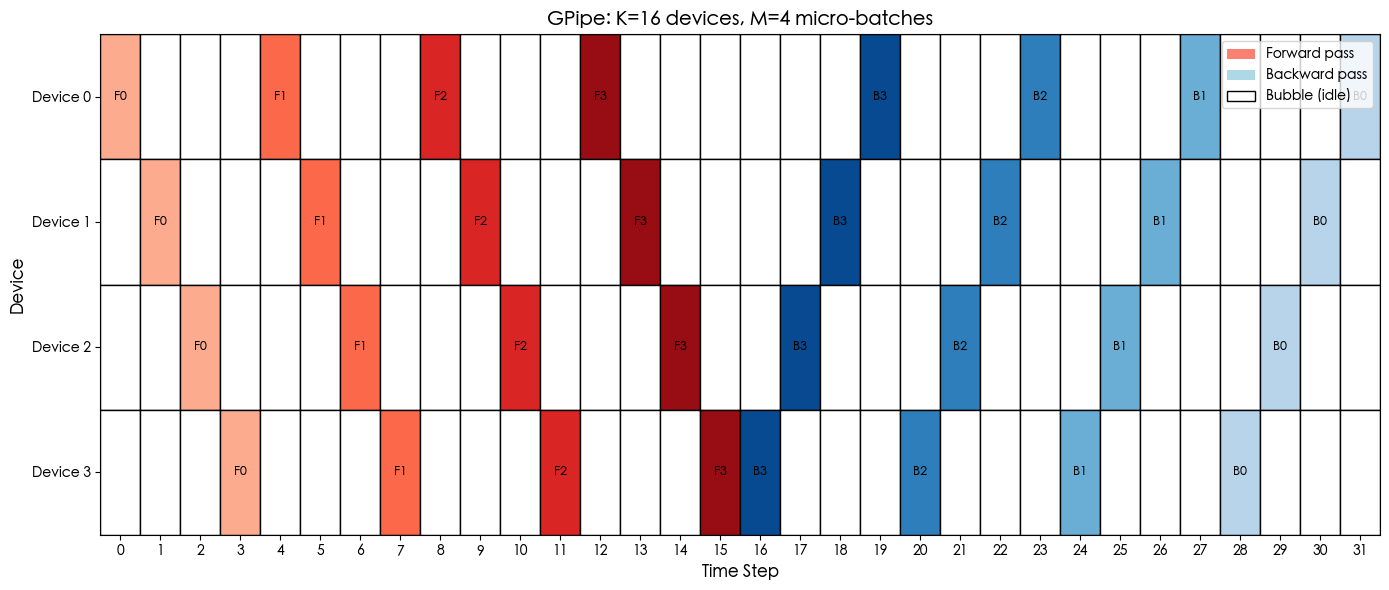


Bubble Time Analysis (K=16, M=4):
  Theoretical bubble fraction: 0.789 (78.9%)
  Actual bubble fraction:      0.750 (75.0%)
  Pipeline efficiency:         25.0%

✓ Schedule visualization complete!


In [7]:
def visualize_pipeline_schedule(pipeline: GPipePipeline, title: str = "GPipe Schedule (F-then-B)"):
    """Visualize pipeline execution timeline."""
    timeline = pipeline.get_timeline_matrix()
    K, T = timeline.shape
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create color map
    # Positive = forward (warm colors), negative = backward (cool colors), 0 = bubble (white)
    M = int(np.max(np.abs(timeline)))
    colors_forward = plt.cm.Reds(np.linspace(0.3, 0.9, M))
    colors_backward = plt.cm.Blues(np.linspace(0.3, 0.9, M))
    
    # Plot timeline
    for k in range(K):
        for t in range(T):
            val = timeline[k, t]
            if val > 0:  # Forward
                color = colors_forward[int(val) - 1]
                label = f'F{int(val)-1}'
            elif val < 0:  # Backward
                color = colors_backward[int(-val) - 1]
                label = f'B{int(-val)-1}'
            else:  # Bubble
                color = 'white'
                label = ''
            
            rect = plt.Rectangle((t, k), 1, 1, facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            
            if label:
                ax.text(t + 0.5, k + 0.5, label, ha='center', va='center', 
                       fontsize=9, fontweight='bold')
    
    ax.set_xlim(0, T)
    ax.set_ylim(0, K)
    ax.set_xlabel('Time Step', fontsize=12)
    ax.set_ylabel('Device', fontsize=12)
    ax.set_yticks(np.arange(K) + 0.5)
    ax.set_yticklabels([f'Device {k}' for k in range(K)])
    ax.set_xticks(np.arange(T) + 0.5)
    ax.set_xticklabels(np.arange(T))
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='salmon', label='Forward pass'),
        Patch(facecolor='lightblue', label='Backward pass'),
        Patch(facecolor='white', edgecolor='black', label='Bubble (idle)')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()


def compute_actual_bubble_time(timeline: np.ndarray) -> float:
    """Compute actual bubble fraction from timeline."""
    total_steps = timeline.size
    bubble_steps = np.sum(timeline == 0)
    return bubble_steps / total_steps


# Visualize the pipeline we created earlier
print("Visualizing GPipe pipeline schedule...\n")

visualize_pipeline_schedule(pipeline_remat, f"GPipe: K={K} devices, M={M} micro-batches")

# Analyze bubble time
timeline = pipeline_remat.get_timeline_matrix()
actual_bubble = compute_actual_bubble_time(timeline)
theoretical_bubble = compute_bubble_fraction(K, M)

print(f"\nBubble Time Analysis (K={K}, M={M}):")
print(f"  Theoretical bubble fraction: {theoretical_bubble:.3f} ({theoretical_bubble*100:.1f}%)")
print(f"  Actual bubble fraction:      {actual_bubble:.3f} ({actual_bubble*100:.1f}%)")
print(f"  Pipeline efficiency:         {(1-actual_bubble)*100:.1f}%")

print("\n✓ Schedule visualization complete!")

# 第7节：比较 - 流水线 vs 数据并行

让我们比较 GPipe（流水线并行）与传统数据并行。

## 数据并行
- 在每个设备上复制整个模型
- 在设备间拆分批次
- 同步梯度（all-reduce）
- **限制**: 模型必须能放入单个设备

## 流水线并行 (GPipe)
- 在设备间拆分模型
- 所有设备在同一批次上工作（不同微批）
- 无需梯度同步
- **优势**: 可以训练超过单个设备内存的模型

In [8]:
def simulate_data_parallelism(model_layers: List[Layer], 
                             batch_size: int, 
                             num_devices: int) -> Dict[str, float]:
    """Simulate data parallelism timing.
    
    Returns:
        Dictionary with timing breakdown
    """
    # Each device processes batch_size/num_devices examples
    local_batch_size = batch_size // num_devices
    
    # Timing (arbitrary units)
    forward_time = len(model_layers) * 1.0  # One unit per layer
    backward_time = len(model_layers) * 1.0
    allreduce_time = 2.0  # Communication overhead
    
    total_time = forward_time + backward_time + allreduce_time
    
    return {
        'forward': forward_time,
        'backward': backward_time,
        'communication': allreduce_time,
        'total': total_time,
        'efficiency': (forward_time + backward_time) / total_time
    }


def simulate_pipeline_parallelism(model_layers: List[Layer],
                                 batch_size: int,
                                 num_devices: int,
                                 num_microbatches: int) -> Dict[str, float]:
    """Simulate pipeline parallelism timing."""
    layers_per_device = len(model_layers) // num_devices
    
    # Time for one micro-batch through one partition
    forward_time_per_micro = layers_per_device * 1.0
    backward_time_per_micro = layers_per_device * 1.0
    
    # Total pipeline time
    # Fill pipeline: (K-1) + M micro-batches
    # Each step: forward or backward through one partition
    total_forward_steps = (num_devices - 1) + num_microbatches
    total_backward_steps = (num_devices - 1) + num_microbatches
    
    total_time = (total_forward_steps + total_backward_steps) * layers_per_device
    
    # Compute time (excluding bubbles)
    compute_time = 2 * num_microbatches * layers_per_device * num_devices
    
    return {
        'forward': total_forward_steps * layers_per_device,
        'backward': total_backward_steps * layers_per_device,
        'communication': 0,  # No inter-device communication!
        'total': total_time,
        'efficiency': compute_time / (total_time * num_devices),
        'bubble_fraction': compute_bubble_fraction(num_devices, num_microbatches)
    }


# Compare both approaches
print("Comparing Pipeline Parallelism vs Data Parallelism\n")
print("="*70)

total_layers = 12
batch_size = 32
num_devices = 4
num_microbatches = 8

# Simulate data parallelism
data_parallel_stats = simulate_data_parallelism(model_layers, batch_size, num_devices)

print("Data Parallelism:")
print(f"  Configuration: {num_devices} devices, batch size {batch_size}")
print(f"  Forward time:        {data_parallel_stats['forward']:.1f} units")
print(f"  Backward time:       {data_parallel_stats['backward']:.1f} units")
print(f"  Communication time:  {data_parallel_stats['communication']:.1f} units (all-reduce)")
print(f"  Total time:          {data_parallel_stats['total']:.1f} units")
print(f"  Efficiency:          {data_parallel_stats['efficiency']*100:.1f}%")
print(f"  ⚠️  Limitation: Model must fit on single device!")

print("\n" + "="*70)

# Simulate pipeline parallelism
pipeline_stats = simulate_pipeline_parallelism(model_layers, batch_size, num_devices, num_microbatches)

print("Pipeline Parallelism (GPipe):")
print(f"  Configuration: {num_devices} devices, {num_microbatches} micro-batches")
print(f"  Forward time:        {pipeline_stats['forward']:.1f} units")
print(f"  Backward time:       {pipeline_stats['backward']:.1f} units")
print(f"  Communication time:  {pipeline_stats['communication']:.1f} units (none!)")
print(f"  Total time:          {pipeline_stats['total']:.1f} units")
print(f"  Efficiency:          {pipeline_stats['efficiency']*100:.1f}%")
print(f"  Bubble fraction:     {pipeline_stats['bubble_fraction']*100:.1f}%")
print(f"  ✓ Advantage: Can train models {num_devices}× larger!")

print("\n" + "="*70)
print("\nKey Differences:")
print("  • Data parallel: Fast, but model must fit on one device")
print("  • Pipeline parallel: Enables training of giant models")
print("  • GPipe: No communication overhead (unlike data parallel)")
print("  • Trade-off: Pipeline has bubble time, data parallel has communication")

print("\n✓ Comparison complete!")

Comparing Pipeline Parallelism vs Data Parallelism

Data Parallelism:
  Configuration: 4 devices, batch size 32
  Forward time:        11.0 units
  Backward time:       11.0 units
  Communication time:  2.0 units (all-reduce)
  Total time:          24.0 units
  Efficiency:          91.7%
  ⚠️  Limitation: Model must fit on single device!

Pipeline Parallelism (GPipe):
  Configuration: 4 devices, 8 micro-batches
  Forward time:        22.0 units
  Backward time:       22.0 units
  Communication time:  0.0 units (none!)
  Total time:          44.0 units
  Efficiency:          72.7%
  Bubble fraction:     27.3%
  ✓ Advantage: Can train models 4× larger!


Key Differences:
  • Data parallel: Fast, but model must fit on one device
  • Pipeline parallel: Enables training of giant models
  • GPipe: No communication overhead (unlike data parallel)
  • Trade-off: Pipeline has bubble time, data parallel has communication

✓ Comparison complete!


# 第8节：完整的 GPipe 训练循环

让我们整合所有内容: 使用 GPipe 的完整训练循环。

In [9]:
def compute_loss(outputs: List[np.ndarray], labels: List[np.ndarray]) -> float:
    """Compute average loss across micro-batches (MSE for simplicity)."""
    total_loss = 0.0
    for output, label in zip(outputs, labels):
        total_loss += np.mean((output - label) ** 2)
    return total_loss / len(outputs)


def train_gpipe_epoch(pipeline: GPipePipelineWithRemat,
                     X_train: np.ndarray,
                     y_train: np.ndarray,
                     batch_size: int,
                     num_microbatches: int,
                     learning_rate: float) -> List[float]:
    """Train one epoch with GPipe.
    
    Returns:
        List of losses for each mini-batch
    """
    num_samples = X_train.shape[0]
    num_batches = num_samples // batch_size
    
    losses = []
    
    for batch_idx in range(num_batches):
        # Get mini-batch
        start = batch_idx * batch_size
        end = start + batch_size
        X_batch = X_train[start:end]
        y_batch = y_train[start:end]
        
        # Split into micro-batches
        microbatches = split_into_microbatches(X_batch, y_batch, num_microbatches)
        
        # Forward pass
        outputs, boundary_inputs = pipeline.forward_pipeline_remat(microbatches)
        
        # Compute loss
        labels = [mb[1] for mb in microbatches]
        loss = compute_loss(outputs, labels)
        losses.append(loss)
        
        # Backward pass
        all_gradients = pipeline.backward_pipeline_remat(outputs, labels, boundary_inputs)
        
        # Accumulate gradients
        accumulated_grads = accumulate_gradients(all_gradients)
        
        # Update parameters
        apply_gradients(pipeline.partitions, accumulated_grads, learning_rate)
    
    return losses


# Generate synthetic dataset
print("Creating synthetic dataset...\n")

num_train = 256
input_dim = 128
output_dim = 10

X_train = np.random.randn(num_train, input_dim)
y_train_labels = np.random.randint(0, output_dim, num_train)
y_train = np.eye(output_dim)[y_train_labels]

print(f"Dataset: {num_train} samples, input dim {input_dim}, output dim {output_dim}")

# Create fresh model and pipeline
print("\nInitializing GPipe model...")

layer_dims = [input_dim] + [256] * 10 + [output_dim]
activations = ['relu'] * 10 + ['linear']
model_layers = create_model(layer_dims, activations)

K = 4
partitions = partition_model(model_layers, K)
pipeline = GPipePipelineWithRemat(partitions)

print(f"  Model: {len(model_layers)} layers")
print(f"  Partitions: {K} devices")

# Training configuration
batch_size = 32
num_microbatches = 8
learning_rate = 0.001
num_epochs = 3

print(f"\nTraining configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Micro-batches: {num_microbatches}")
print(f"  Learning rate: {learning_rate}")
print(f"  Epochs: {num_epochs}")

# Train
print("\n" + "="*70)
print("Training GPipe model...")
print("="*70 + "\n")

all_losses = []

for epoch in range(num_epochs):
    pipeline.events = []  # Reset events for this epoch
    
    losses = train_gpipe_epoch(pipeline, X_train, y_train, 
                               batch_size, num_microbatches, learning_rate)
    
    avg_loss = np.mean(losses)
    all_losses.extend(losses)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Average Loss = {avg_loss:.6f}")

print("\n✓ Training complete!")

Creating synthetic dataset...

Dataset: 256 samples, input dim 128, output dim 10

Initializing GPipe model...
  Model: 11 layers
  Partitions: 4 devices

Training configuration:
  Batch size: 32
  Micro-batches: 8
  Learning rate: 0.001
  Epochs: 3

Training GPipe model...

Epoch 1/3: Average Loss = 0.399302
Epoch 2/3: Average Loss = 0.167322
Epoch 3/3: Average Loss = 0.140893

✓ Training complete!


# 第9节：可视化和分析

让我们创建 GPipe 性能的全面可视化。

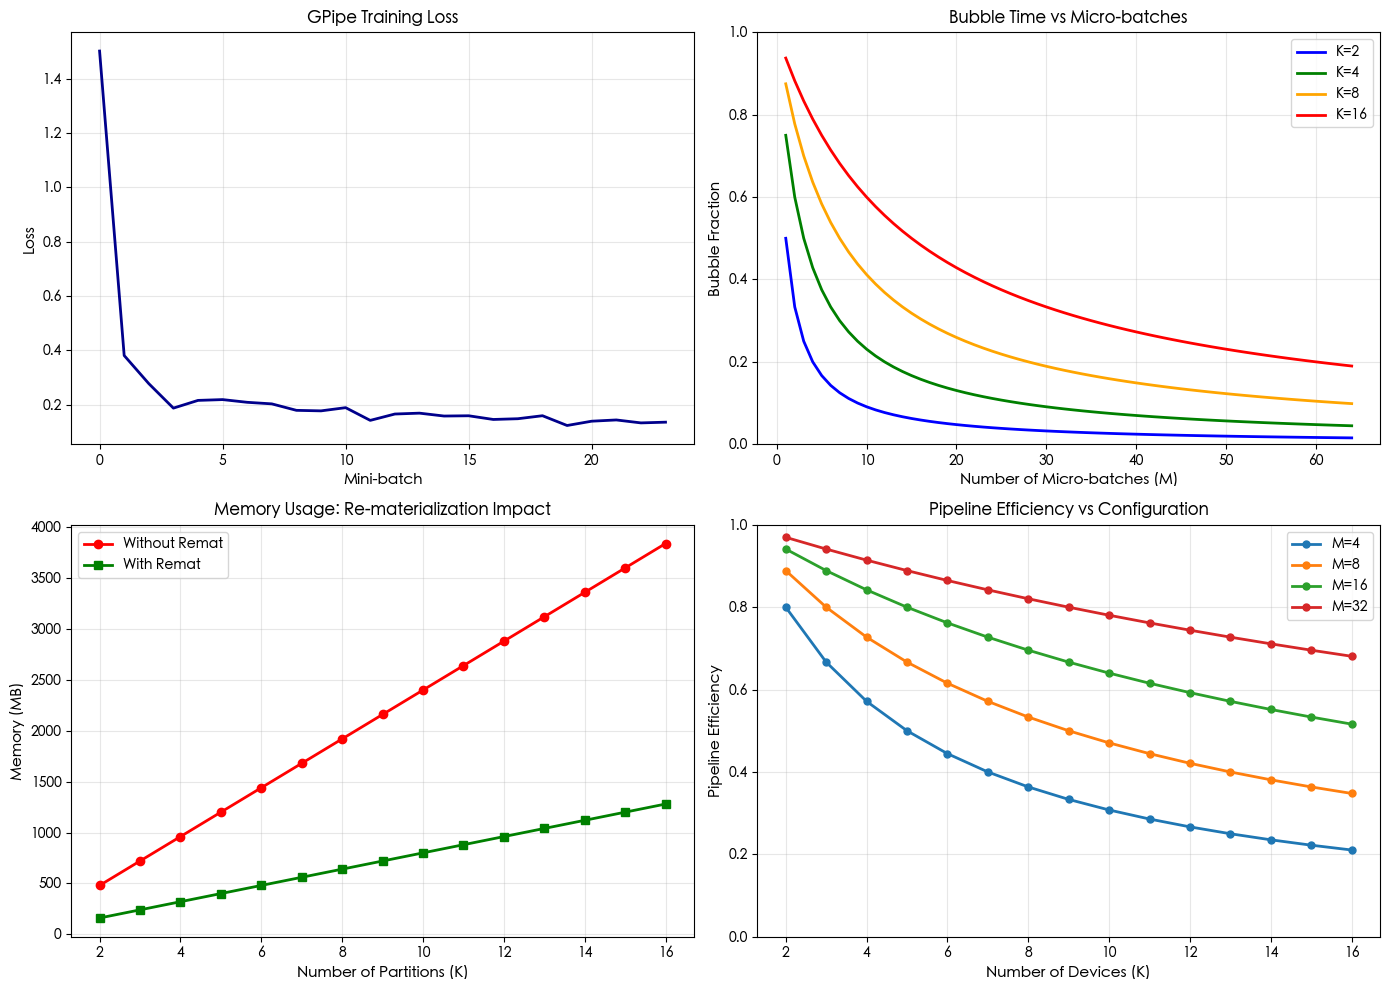


✓ Visualizations complete!


In [10]:
# Visualization 1: Training Loss Curve
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Training loss
ax = axes[0, 0]
ax.plot(all_losses, linewidth=2, color='darkblue')
ax.set_xlabel('Mini-batch', fontsize=11)
ax.set_ylabel('Loss', fontsize=11)
ax.set_title('GPipe Training Loss', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Bubble fraction vs M (micro-batches)
ax = axes[0, 1]
M_range = np.arange(1, 65)
K_values_plot = [2, 4, 8, 16]
colors = ['blue', 'green', 'orange', 'red']

for K_val, color in zip(K_values_plot, colors):
    bubbles = [compute_bubble_fraction(K_val, M) for M in M_range]
    ax.plot(M_range, bubbles, label=f'K={K_val}', linewidth=2, color=color)

ax.set_xlabel('Number of Micro-batches (M)', fontsize=11)
ax.set_ylabel('Bubble Fraction', fontsize=11)
ax.set_title('Bubble Time vs Micro-batches', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Plot 3: Memory savings with re-materialization
ax = axes[1, 0]
K_range = np.arange(2, 17)
layers_per_partition = 3
M_fixed = 8
activation_size_mb = 10

mem_without_remat = [estimate_memory_usage(M_fixed, K_val, layers_per_partition, 
                                            activation_size_mb, False) 
                     for K_val in K_range]
mem_with_remat = [estimate_memory_usage(M_fixed, K_val, layers_per_partition, 
                                        activation_size_mb, True) 
                  for K_val in K_range]

ax.plot(K_range, mem_without_remat, label='Without Remat', linewidth=2, 
        marker='o', color='red', markersize=6)
ax.plot(K_range, mem_with_remat, label='With Remat', linewidth=2, 
        marker='s', color='green', markersize=6)
ax.set_xlabel('Number of Partitions (K)', fontsize=11)
ax.set_ylabel('Memory (MB)', fontsize=11)
ax.set_title('Memory Usage: Re-materialization Impact', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Pipeline efficiency vs configuration
ax = axes[1, 1]
M_configs = [4, 8, 16, 32]
K_configs = np.arange(2, 17)

for M_val in M_configs:
    efficiencies = [1 - compute_bubble_fraction(K_val, M_val) for K_val in K_configs]
    ax.plot(K_configs, efficiencies, label=f'M={M_val}', linewidth=2, marker='o', markersize=5)

ax.set_xlabel('Number of Devices (K)', fontsize=11)
ax.set_ylabel('Pipeline Efficiency', fontsize=11)
ax.set_title('Pipeline Efficiency vs Configuration', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

print("\n✓ Visualizations complete!")

# 第10节：关键洞察和现代扩展

## GPipe 总结

### 核心思想
1. **流水线并行**: 按层在设备间拆分模型
2. **微批处理**: 拆分小批以减少气泡时间
3. **重计算**: 以计算换内存效率
4. **F-then-B 调度**: 前向所有微批，然后反向所有

### 数学洞察

**气泡比例**:
$$\text{气泡} = \frac{K-1}{K-1+M}$$

**内存节省**（使用重计算）:
$$\text{内存}_{\text{remat}} = \frac{K}{L} \times \text{内存}_{\text{标准}}$$

其中 L = 总层数，K = 分区数。

**加速**（相比单个设备）:
$$\text{加速} \approx \frac{K}{1 + \frac{K-1}{M}}$$

### 何时使用 GPipe

**使用 GPipe 当**:
- 模型无法放入单个设备
- 顺序模型结构（层）
- 设备间带宽有限
- 可以使用大的 M（许多微批）

**避免 GPipe 当**:
- 模型能放入单个设备（改用数据并行）
- M 很小（气泡时间占主导）
- 非顺序架构（例如，大量跳跃连接）

---

## 现代扩展

### 1. PipeDream (Harlap et al., 2018)
- **1F1B 调度**: 交织前向和反向
- 减少流水线深度
- 更好的内存效率

### 2. Megatron-LM (Shoeybi et al., 2019)
- 结合流水线 + 张量并行
- 水平拆分层（层内）
- 用于 530B 参数模型

### 3. ZeRO (Rajbhandari et al., 2020)
- 分区优化器状态、梯度、参数
- 补充流水线并行
- 无复制地减少内存

### 4. Varuna (Athlur et al., 2022)
- 自动流水线调度优化
- 自适应微批处理
- 处理异构设备

---

## 实际考虑

### 最优 M（微批数）
- **太小**: 高气泡比例
- **太大**: 微批管理的开销
- **经验法则**: M ≈ 4×K

### 分区策略
- 均匀: 每个设备等量层
- 平衡: 每个设备等量计算时间
- 内存感知: 平衡内存使用

### 批次大小
- 大批次提高流水线利用率
- 但可能损害泛化
- 通过学习率缩放补偿

---

## 与其他论文的联系

**Paper 5 (Optimal Brain Damage)**: 剪枝减少模型大小 → 需要更少流水线阶段

**Paper 23 (MDL)**: 模型复杂度 vs 数据拟合 → 选择 K（分区）涉及权衡

**Paper 14 (Neural Architecture Search)**: 可以使用 GPipe 搜索对单个设备来说太大的架构

---

## 实际影响

GPipe 使得:
- **AmoebaNet-B**: 557M 参数（比之前最好的大 8 倍）
- **在 ImageNet 上训练**，达到 84.4% top-1 准确率
- **GPT-3**: 175B 参数（包括流水线并行在内的技术组合）
- **大型语言模型**: 现代 LLM 使用流水线 + 张量 + 数据并行

---

**GPipe 的遗产**: 表明**模型并行是实用的**，为训练具有数千亿参数的模型铺平了道路。与张量并行和 ZeRO 结合，它构成了现代大规模训练的基础！

In [11]:
# Final demonstration: Show trade-off between K and M
print("="*70)
print("GPipe Configuration Guide")
print("="*70)

print("\n1. Choosing K (number of devices):")
print("   • Limited by: Number of available accelerators")
print("   • More K = Can train larger models")
print("   • More K = More bubble time (need larger M to compensate)")

print("\n2. Choosing M (number of micro-batches):")
print("   • Rule of thumb: M ≈ 4×K")
print("   • Larger M = Less bubble time")
print("   • Larger M = More overhead")
print("   • Must divide batch size evenly")

print("\n3. Example configurations:")
configs = [
    (2, 8, 32),
    (4, 16, 64),
    (8, 32, 128),
    (16, 64, 256),
]

for K, M, batch in configs:
    bubble = compute_bubble_fraction(K, M)
    efficiency = 1 - bubble
    print(f"   K={K:2d}, M={M:2d}, batch={batch:3d} → "
          f"Efficiency={efficiency*100:.1f}%, Bubble={bubble*100:.1f}%")

print("\n" + "="*70)
print("✓ GPipe implementation complete!")
print("="*70)

GPipe Configuration Guide

1. Choosing K (number of devices):
   • Limited by: Number of available accelerators
   • More K = Can train larger models
   • More K = More bubble time (need larger M to compensate)

2. Choosing M (number of micro-batches):
   • Rule of thumb: M ≈ 4×K
   • Larger M = Less bubble time
   • Larger M = More overhead
   • Must divide batch size evenly

3. Example configurations:
   K= 2, M= 8, batch= 32 → Efficiency=88.9%, Bubble=11.1%
   K= 4, M=16, batch= 64 → Efficiency=84.2%, Bubble=15.8%
   K= 8, M=32, batch=128 → Efficiency=82.1%, Bubble=17.9%
   K=16, M=64, batch=256 → Efficiency=81.0%, Bubble=19.0%

✓ GPipe implementation complete!
